In [1]:
%load_ext autoreload
%autoreload 2

# Análisis de Hacinamiento de Vivienda en Chile con Machine Learning

## Justificación y Objetivos
Tenemos un dataset con 40 columnas que tienen información relacionada a 31652 viviendas en Chile.

Me gustaría realizar un modelo que prediga el hacinamiento de un hogar, dada su situación particular. Esto principalmente porque es un análisis directo, con muchas implicancias asociadas a la desigualdad nacional y porque personalmente quiero entender mejor las relaciones que pueden exisitir.

El hacinamiento es un indicador directo de la calidad de vida y la vulnerabilidad de un hogar.


## Definición del problema

Predecir si un hogar se encuentra en situación de hacinamiento.

El hacinamiento es un indicador clave de vulnerabilidad y calidad de vida. Un modelo que lo prediga bien podría ser muy útil para políticas públicas.

### Definición de la Variable Objetivo:

Crearemos una nueva variable binaria hacinamiento_flag. Vamos a usar un umbral de más de 2 personas por dormitorio(Que dependiendo de la situación puede ser bastante).

## Modelo 
Para hacer este análisis decidí usar el modelo CATBOOST. He escuchado comentarios muy positiovs y ya llevo bastante tiempo queriendo usarlo. Por supuesto también es un modelo con una buena reputación para trabajr con información tabular y categorica. Lo único que me lamento es no tener un dataset mas grande.


## hipotesis
Hipótesis 1 (Socioeconómica): El nivel educativo del jefe de hogar (jefe_hogar_educacion) y la tenencia de la vivienda (tenencia_vivienda - ej. 'Ocupación irregular') serán predictores importantes. Se espera que niveles educativos más bajos y tenencia irregular se asocien con una mayor probabilidad de hacinamiento.

Hipótesis 2 (Geográfica): La comuna será un factor determinante, reflejando que el hacinamiento se concentra en ciertas áreas geográficas con mercados de vivienda más caros o con mayor vulnerabilidad.

Hipótesis 3 (Demográfica): Características demográficas como el porc_menores_18 (porcentaje de menores) estarán positivamente correlacionadas con el hacinamiento.

## EDA

In [2]:

# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from data_observatory_test_062025.load_data_viviendas import load_interim_data
from data_observatory_test_062025.generic_eda_report import generic_report

# 2. Configurar estilo de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 3. Cargar el dataset limpio de la Pregunta 2
try:
    df_vivienda = load_interim_data()
    print("Dataset limpio cargado exitosamente.")
except FileNotFoundError:
    print("Error: Ejecute primero la Pregunta 2 para generar 'datos_viviendas_censo_limpio.csv'")
    exit()

2025-06-06 01:56:08.505 | INFO     | data_observatory_test_062025.config:<module>:11 - PROJ_ROOT path is: /var/home/felipecabello/git/data_observatory_test_062025


Dataset limpio cargado exitosamente.


In [3]:
# Lo primero es dejar como referencia al tope del archivo una descripción general del dataset

# Me llama la atención esa variable "Unnamed:0", parece que se coló un índice extra jaja

generic_report(df_vivienda)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31652 entries, 0 to 31651
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          31652 non-null  int64  
 1   id_vivienda                         31652 non-null  object 
 2   comuna                              31652 non-null  object 
 3   tipo_vivienda                       31652 non-null  object 
 4   num_dormitorios                     31652 non-null  int64  
 5   num_banos                           31652 non-null  int64  
 6   superficie_m2                       31652 non-null  float64
 7   ano_construccion                    31652 non-null  int64  
 8   material_paredes                    31652 non-null  object 
 9   material_techo                      31652 non-null  object 
 10  num_personas_hogar                  31652 non-null  int64  
 11  num_hombres                         31652

In [4]:

df_cleaned = df_vivienda.drop(columns=[
    'Unnamed: 0',
    'id_vivienda',
    'indice_masculinidad', # Colineal con genero
    'ingreso_mensual_hogar',  # Ya no es nuestro target
    'ingreso_per_capita'      # Fuga de datos del problema anterior
])

# --- 1. Creación de la Variable Objetivo: 'hacinamiento_flag' ---
# Definimos hacinamiento como > 2 personas por dormitorio.
df_cleaned['hacinamiento_flag'] = (df_cleaned['personas_por_dormitorio'] > 2).astype(int)

# --- 2. Análisis Exploratorio de la Nueva Variable Objetivo ---
print("Distribución de la variable 'hacinamiento_flag':")
print(df_cleaned['hacinamiento_flag'].value_counts(normalize=True))



Distribución de la variable 'hacinamiento_flag':
hacinamiento_flag
1    0.513964
0    0.486036
Name: proportion, dtype: float64


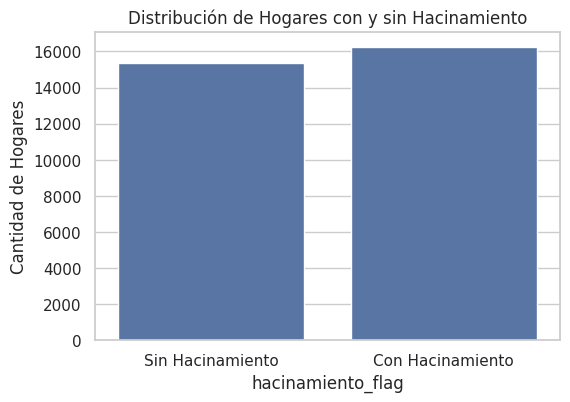

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='hacinamiento_flag', data=df_cleaned)
plt.title('Distribución de Hogares con y sin Hacinamiento')
plt.xticks([0, 1], ['Sin Hacinamiento', 'Con Hacinamiento'])
plt.ylabel('Cantidad de Hogares')
plt.show()

Tenemos clases bastante balanceadas


In [6]:
# Eliminar las variables que componen directamente la variable objetivo para evitar fuga de datos.
# El modelo debe predecir el hacinamiento a partir de características socioeconómicas,
# no a partir de un cálculo directo.
X = df_cleaned.drop(columns=[
    'hacinamiento_flag',
    'personas_por_dormitorio', # Fuga de datos directa
    'num_personas_hogar',      # Fuga de datos fuerte
    'num_dormitorios',          # Fuga de datos fuerte
    'superficie_m2' # Lo haría muy facil
])
y = df_cleaned['hacinamiento_flag']

# Identificar las variables categóricas para CatBoost
categorical_features_indices = [X.columns.get_loc(c) for c in X.select_dtypes(include=['object', 'bool']).columns]

print(f"Features utilizados para la predicción: {X.columns.tolist()}")

Features utilizados para la predicción: ['comuna', 'tipo_vivienda', 'num_banos', 'ano_construccion', 'material_paredes', 'material_techo', 'num_hombres', 'num_mujeres', 'num_menores_18', 'num_adultos_18_64', 'num_adultos_65_plus', 'jefe_hogar_edad', 'jefe_hogar_sexo', 'jefe_hogar_educacion', 'agua_potable', 'electricidad', 'gas_natural', 'internet', 'telefono_fijo', 'vehiculo_propio', 'tenencia_vivienda', 'suma_etarios', 'suma_genero', 'Departamento_madera_flag', 'MediaAgua_Hormigon_flag', 'Departamento_techo_paja_flag', 'Casa_pareada_techo_paja_flag', 'techo_rustico_paredes_premium_flag', 'media_agua_losa_flag', 'losa_adobe_flag', 'score_inconsistencias', 'porc_menores_18', 'porc_adultos_18_64', 'porc_adultos_65_plus', 'suma_servicios_basicos']


In [7]:

# División estratificada para mantener la proporción de clases en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model_clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features_indices,
    verbose=0,
    random_seed=42,
    eval_metric='Accuracy' # un clasico
)

# Usamos StratifiedKFold para la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluamos usando tanto Accuracy como AUC-ROC
scoring_metrics = ['accuracy', 'roc_auc']
for metric in scoring_metrics:
    cv_scores = cross_val_score(model_clf, X_train, y_train, cv=cv, scoring=metric)
    print(f"{metric.upper()} promedio en validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

ACCURACY promedio en validación cruzada: 0.7804 (+/- 0.0029)
ROC_AUC promedio en validación cruzada: 0.8878 (+/- 0.0033)


In [8]:
# Entrenar el modelo final y evaluar en el conjunto de prueba
model_clf.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Predecir clases
y_pred_class = model_clf.predict(X_test)

# Calcular métricas finales
accuracy_final = accuracy_score(y_test, y_pred_class)
roc_auc_final = roc_auc_score(y_test, model_clf.predict_proba(X_test)[:, 1]) # AUC necesita probabilidades

print(f"\n--- Resultados en el Conjunto de Prueba ---")
print(f"Accuracy Final: {accuracy_final:.4f}")
print(f"AUC-ROC Final: {roc_auc_final:.4f}")

# La matriz de confusión y el reporte de clasificación siguen siendo muy útiles
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_class))

print("\nReporte de Clasificación:")
# En un caso balanceado, el F1-score, Precision y Recall para ambas clases serán similares
# si el modelo es bueno.
print(classification_report(y_test, y_pred_class, target_names=['Sin Hacinamiento', 'Con Hacinamiento']))


--- Resultados en el Conjunto de Prueba ---
Accuracy Final: 0.7989
AUC-ROC Final: 0.8884

Matriz de Confusión:
[[2697  380]
 [ 893 2361]]

Reporte de Clasificación:
                  precision    recall  f1-score   support

Sin Hacinamiento       0.75      0.88      0.81      3077
Con Hacinamiento       0.86      0.73      0.79      3254

        accuracy                           0.80      6331
       macro avg       0.81      0.80      0.80      6331
    weighted avg       0.81      0.80      0.80      6331



## Comentarios finales

Se implementó un CatBoostClassifier. Dada la naturaleza balanceada de las clases, no se requirieron técnicas de re-muestreo. El modelo fue validado mediante validación cruzada estratificada (5-folds), asegurando la robustez de la evaluación. Posteriormente, se entrenó un modelo final en el 80% de los datos y se evaluó en el 20% restante (conjunto de prueba).

Se obtuvieron resultados satisfactorios, con:
- Accuracy Final: 0.7804

- AUC-ROC Final: 0.8884

Es decir, una buena precisión general y un alto poder de discriminación. Hay un 86 % de probabilidad de que el modelo asigne una puntuación de riesgo mas alta al hogar hacinado y una precisión de el 79.89%.

Lamentablemente, con 893 falsos negativos, me parece que el modelo si es muy conservador, con un 27% de hogares hacinados clasificados erroneamente.

## Conclusiones

1. La hipótesis inicial, que decía que las variables economicas, demograficas y geograficas son determiantes para el hacinamiento, fue validada.
2. Se logró predecir el hacinamiento con un modelo bastante robusto. Aunque existen oportunidades de mejora.
3. Este modelo podría tener una aplicación práctica para focalizar recursos de manera preventiva a secotres con alto riesgo de hacinamiento.

## Limitaciones

1. Si bien los resultados son prometedores, es importante recalcar que los resultados no implican una Causalidad.

2. La calidad de los datos limita la calidad del modelo. Con mejores datos, tendremos un modelo más robusto

3. La definición del umbral es un punto crítico en este análsis. Si este no es apropiado, el modelo queda comprometido.

